# Load data

In [ ]:
import pandas as pd

# differences between final_df3 and final_df are the filter_spans and word_count columns
final_df3 = pd.read_excel("../data/final_df3.xlsx")
final_df3.rename(columns={"entity":"aspect"}, inplace=True)
final_df3.head()

,original_text,text,aspect,opinion,emotion,filtered_spans,word_count
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11
3,"Kama Dege That’s how propaganda works. Russia,...",Kama Dege That’s how propaganda works.,propaganda,works,NEUTRAL,"[(0, 8), (0, 9), (0, 10), (1, 8), (1, 9), (1, ...",6
4,"Kama Dege That’s how propaganda works. Russia,...",So no love from the world.,world,no love,SADNESS,"[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2...",6


# Loading from .py scripts.
Adjust the import statements to match the current version

In [ ]:
import torch
from models.encoder import SentenceEncoder
from models.mention import MentionClassifier
from models.triplet import TripletClassifier
from data.dataset import setup_dataloader

# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SentenceEncoder(cache_dir="../span_aste/huggingface_models").to(device)
embedding_dim = encoder.bert.config.hidden_size
mention_model = MentionClassifier(input_dim=embedding_dim).to(device)
triplet_model = TripletClassifier(input_dim=embedding_dim, num_classes=4).to(device)

# Prepare data
dataloader, tokenizer = setup_dataloader(final_df3, tokenizer=encoder.tokenizer, batch_size=2)

# Function needed for more processing

## Finding missing spans

In [ ]:
import ast

# Utility to generate all valid spans up to max length
def enumerate_spans(sentence_len, max_span_len=10):
    return [(i, j) for i in range(sentence_len) for j in range(i, min(i + max_span_len, sentence_len))]

def find_missing_spans(row, tokenizer, max_span_len=10, filtered_spans=True):

    text = row['text']
    annotations = row['annotations']  # list of dicts with aspect, opinion, emotion

    tokens = tokenizer.tokenize(text.lower())

    if filtered_spans and "filtered_spans" in row:
        spans = ast.literal_eval(row["filtered_spans"])
    else:
        spans = enumerate_spans(len(tokens), max_span_len)

    # Build index of all annotated target/opinion spans
    target_spans = set()
    opinion_spans = set()
    labeled_triplets = {}

    def find_span(entity, tokens, tokenizer):
        entity_tokens = tokenizer.tokenize(entity.lower())
        entity_tokens = [t.lstrip('##') for t in entity_tokens]  # Remove BERT subword markers

        norm_tokens = [t.lstrip('##') for t in tokens]  # Also normalize input tokens

        # Try to find the span in normalized tokens
        for i in range(len(norm_tokens) - len(entity_tokens) + 1):
            if norm_tokens[i:i + len(entity_tokens)] == entity_tokens:
                return i, i + len(entity_tokens) - 1

        return None

    ann_list = []
    for ann in annotations:
        aspect_span = find_span(ann['aspect'], tokens, tokenizer)
        opinion_span = find_span(ann['opinion'], tokens, tokenizer)

        if aspect_span is None:
            print(f"[MISSING ASPECT] \"{ann['aspect']}\" in: \"{text}\"")
            ann_list.append({
                'missing_aspect':ann['aspect'],
                'missing_opinion': "",
                'text': text
            })
        if opinion_span is None:
            print(f"[MISSING OPINION] \"{ann['opinion']}\" in: \"{text}\"")
            ann_list.append({
                'missing_aspect': "",
                'missing_opinion': ann['opinion'],
                'text': text
            })

    return ann_list
def group_rows_by_text_df(df):
    grouped = (
        df.groupby('text', group_keys=False)
          .apply(lambda g: {
              'text': g.name,
              'annotations': g[['aspect', 'opinion', 'emotion']].to_dict(orient='records')
          }, include_groups=False)
          .tolist()
    )
    return grouped

In [ ]:
# Group the full DataFrame first
grouped_val = group_rows_by_text_df(final_df3)
A = []

for i in grouped_val:
    row = find_missing_spans(i, tokenizer, max_span_len=20, filtered_spans=True)
    A.extend(row)

In [ ]:
problem_df = pd.DataFrame(A)
bad_texts = problem_df['text'].unique()
cleaned_df = final_df3[~final_df3['text'].isin(bad_texts)].reset_index(drop=True)

## Identifying rows with UNK

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir="../span_aste/huggingface_models")

def contains_unk(text):
    tokens = tokenizer.tokenize(text)
    return "[UNK]" in tokens

# Add a column indicating whether the text has unknown tokens
cleaned_df["has_unk"] = cleaned_df["text"].apply(contains_unk)

# Filter out those rows
cleaned_df2 = cleaned_df[~cleaned_df["has_unk"]].drop(columns=["has_unk"]).reset_index(drop=True)

In [31]:
print(len(cleaned_df2))

cleaned_df2.emotion.value_counts(normalize=True)

10192


emotion
NEUTRAL     0.335754
JOY         0.192700
SADNESS     0.185341
DISGUST     0.174941
ANGER       0.073195
FEAR        0.028061
SURPRISE    0.010008
Name: proportion, dtype: float64

In [63]:
final_df6 = cleaned_df2.copy()

In [66]:
def count_opinion_tokens(opinion):
    tokens = tokenizer.tokenize(str(opinion).lower())
    return len(tokens)

# Create a new column with token counts
final_df6["opinion_token_count"] = final_df6["opinion"].apply(count_opinion_tokens)
final_df6.rename(columns={"aspect":"entity"}, inplace=True)
max(final_df6.opinion_token_count)

21

## Dropping from manual inspection

In [ ]:
Drop = ["A-averageB-badC-cannot come home todayD-disowned",
        "proceeds to type 3 paragraphs12 year olds give that cliche response.",
        "BullshitUnvaccinated over 60 year olds are over 2/3 of our critical care expenditure right now in beds and vastly more in manpower despite making up only 1.5% of the population."]
F = final_df6[final_df6['text'].isin(Drop)].copy()
final_df6 = final_df6[~final_df6['text'].isin(Drop)]

In [68]:
print(len(final_df6))

final_df6.emotion.value_counts(normalize=True)

10186


emotion
NEUTRAL     0.335755
JOY         0.192814
SADNESS     0.185156
DISGUST     0.174946
ANGER       0.073238
FEAR        0.028078
SURPRISE    0.010014
Name: proportion, dtype: float64

In [ ]:
final_df6.to_excel("backup_v5/final_df6.xlsx", index=False)

In [70]:
F

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count
277,BullshitUnvaccinated over 60 year olds are ove...,BullshitUnvaccinated over 60 year olds are ove...,unvaccinated over 60 year olds,making up only 1.5% of the population,NEUTRAL,"[(0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0,...",30,10
4253,A-averageB-badC-cannot come home todayD-disowned,A-averageB-badC-cannot come home todayD-disowned,A,average,NEUTRAL,"[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0...",4,1
4254,A-averageB-badC-cannot come home todayD-disowned,A-averageB-badC-cannot come home todayD-disowned,B,bad,SADNESS,"[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0...",4,1
4255,A-averageB-badC-cannot come home todayD-disowned,A-averageB-badC-cannot come home todayD-disowned,C,cannot come home today,SADNESS,"[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0...",4,4
4256,A-averageB-badC-cannot come home todayD-disowned,A-averageB-badC-cannot come home todayD-disowned,D,disowned,SADNESS,"[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0...",4,4
9195,> proceeds to type 3 paragraphs12 year olds gi...,proceeds to type 3 paragraphs12 year olds give...,12 year olds,give that cliche response,DISGUST,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,5


# Further cleaning

In [ ]:
import pandas as pd

final_df6_Flagged_Rows_for_Manual_Review = pd.read_csv("backup_v5/final_df6_Flagged_Rows_for_Manual_Review.csv")
final_df6 = pd.read_excel("backup_v5/final_df6.xlsx")
final_df7 = final_df6.drop(index=final_df6_Flagged_Rows_for_Manual_Review['Unnamed: 0']).copy()

In [ ]:
# Useless Opinions like "came", "same"

final_df6.iloc[final_df6_Flagged_Rows_for_Manual_Review['Unnamed: 0']]

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count
8,"I had some concerns about the vaccines, and wa...",And now this restriction came...,restriction,came,ANGER,"[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3...",5,1
9,"It's the same with MMORPGs, really. People hav...","It's the same with MMORPGs, really.",MMORPGs,same,NEUTRAL,"[(0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9...",6,1
19,Jerrimae Clamico :\n\n1) The answer is yes bec...,"In Singapore, majorly of Singaporeans do not e...",Singaporeans,do not end up in public local university,SADNESS,"[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6...",22,8
29,I’m a parent of a young kid. Covid is just one...,From what I’ve seen (based on how kids fared i...,risks of covid for kids,do not merit removing them from society,NEUTRAL,"[(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 1...",25,7
30,I’m a parent of a young kid. Covid is just one...,We just focus on covid because it’s ubiquitous...,focus on covid,because it’s ubiquitous in the news,NEUTRAL,"[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7...",25,8
...,...,...,...,...,...,...,...,...
10163,>I don’t understand how this conversation turn...,I don’t understand how this conversation turne...,conversation,"turned into a series of unplanned, rapidly esc...",SADNESS,"[(0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9...",15,15
10168,let's all just pray for peace to be returned t...,let's all just pray for peace to be returned t...,peace,to be returned to the Ukrainian people,SADNESS,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",13,7
10178,Some racists don’t even know they are racists,Some racists don’t even know they are racists.,racists,don’t even know they are racists,NEUTRAL,"[(0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0,...",8,9
10180,vicky li honour the fact that after so many ye...,vicky li honour the fact that after so many ye...,developed country,functions as a caveman mentality,DISGUST,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",22,7


In [ ]:
final_df7.to_excel("backup_v5/final_df7.xlsx", index=False)

### Checking Emoji

In [ ]:
import pandas as pd
import re

# Load your Excel file
final_df7 = pd.read_excel("backup_v5/final_df7.xlsx")

# Simple mapping of demojized emoji names to emotions
emoji_to_emotion = {
    "loudly_crying_face": "SADNESS",
    "crying_face": "SADNESS",
    "smiling_face_with_heart_eyes": "JOY",
    "grinning_face_with_smiling_eyes": "JOY",
    "face_with_symbols_on_mouth": "ANGER",
    "face_vomiting": "DISGUST",
    "scream": "FEAR",
    "astonished_face": "SURPRISE",
    "neutral_face": "NEUTRAL",
    "slightly_smiling_face": "NEUTRAL",
    "pouting_face": "ANGER",
    "confounded_face": "SADNESS"
}

# Regex pattern to find demojized codes
emoji_pattern = re.compile(r":(.*?):")

def check_emoji_emotion_mismatch(row):
    matches = emoji_pattern.findall(str(row['text']))
    for emoji_name in matches:
        expected = emoji_to_emotion.get(emoji_name)
        if expected and expected != row['emotion']:
            return {
                "text": row['text'],
                "aspect": row['entity'],
                "opinion": row['opinion'],
                "emoji": emoji_name,
                "labelled_emotion": row['emotion'],
                "expected_emotion": expected
            }
    return None

import re

def extract_demojized_codes(row):
    text = row.text
    return re.findall(r":(.*?):", str(text))


In [40]:
# Apply and filter
final_df7['extracted_emoji'] = final_df7.apply(extract_demojized_codes, axis=1)

In [ ]:
final_df8 = final_df7.copy()
final_df8.to_excel("backup_v5/final_df8.xlsx")

### final_df8 showed a lot of fucked up emoji and urls

In [ ]:
import pandas as pd
import re

# Load your Excel file
final_df7 = pd.read_excel("backup_v5/final_df7.xlsx")
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4


#### Remove URL

In [58]:
import re

# Function to clean URLs
def clean_urls(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\[.*?\]\(http.*?\)', '', text)
    text = re.sub(r'https?://\S+', '', text)
    return text.strip()

dirty_text = ("As requested:[http://news.bbc.co.uk/2/hi/health/1943420.stm]"
              "(http://news.bbc.co.uk/2/hi/health/1943420.stm)"
              "[https://www.health.harvard.edu/blog/showering-daily-is-it-necessary-2019062617193]"
              "(https://www.health.harvard.edu/blog/showering-daily-is-it-necessary-2019062617193)"
              "Just some additional comments for potentially more downvotes...")

clean_text = clean_urls(dirty_text)
print(clean_text)


As requested:Just some additional comments for potentially more downvotes...


In [59]:
# Apply to the text column
final_df7["text_noURLs"] = final_df7["text"].apply(lambda x: clean_urls(x))

In [61]:
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...


### Extract emojis

In [62]:
import re
import pandas as pd

# Extract and clean emoji codes from text
def extract_emojis(text):
    if not isinstance(text, str):
        return []
    return re.findall(r':[^\s:]+?:', text)

# Remove emoji codes from text
def remove_emojis(text):
    return re.sub(r':[^\s:]+?:', '', text).strip()

# Convert emoji code to readable text
def describe_emojis(emoji_list):
    return ' '.join([e.strip(':').replace('_', ' ') for e in emoji_list])


In [63]:
# Extract emoji codes
final_df7["emoji_list"] = final_df7["text_noURLs"].apply(extract_emojis)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[]
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[]
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[]


In [64]:
# Clean text by removing emoji codes
final_df7["text_noemoji"] = final_df7["text_noURLs"].apply(remove_emojis)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list,text_noemoji
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[],pei shan lin there won't be any complaint?
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...


In [67]:
# Convert emojis to descriptions
final_df7["emoji_text"] = final_df7["emoji_list"].apply(describe_emojis)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list,text_noemoji,emoji_text
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[],pei shan lin there won't be any complaint?,
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,


In [69]:
final_df7["text_final"] = final_df7.apply(
    lambda row: row["text_noemoji"] + (". Emoji: " + row["emoji_text"] if row["emoji_text"] else ""),
    axis=1
)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list,text_noemoji,emoji_text,text_final
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[],pei shan lin there won't be any complaint?,,pei shan lin there won't be any complaint?
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...


### Clean punctuation like contractions, ellipses

In [ ]:
import re

def clean_punctuation(text):
    # Normalize ellipses (replace 2+ dots with "...")
    text = re.sub(r'\.{2,}', '...', text)

    # Replace equal signs used improperly
    text = re.sub(r'(?<=\w)=(?=\w)', ' equals ', text)  # e.g. "a=b" -> "a. b"

    # Normalize common contractions and informal forms
    contractions = {
        r"\bdont\b": "don't",
        r"\bwont\b": "won't",
        r"\bcant\b": "can't",
        r"\bim\b": "I'm",
        r"\bive\b": "I've",
        r"\bidk\b": "I don't know",
    }
    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    return text.strip()


In [80]:
# clean punctuations
final_df7["text_final2"] = final_df7["text_final"].apply(clean_punctuation)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list,text_noemoji,emoji_text,text_final,text_final2
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[],pei shan lin there won't be any complaint?,,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...


### Clean Hashtags

In [84]:
import re

def segment_hashtag(tag):
    # Simple heuristic version: insert space before capital letters or known transitions
    return re.sub(r"([a-z])([A-Z])", r"\1 \2", tag).lower()

def clean_hashtags(text):
    hashtags = re.findall(r"#\w+", text)
    for tag in hashtags:
        phrase = segment_hashtag(tag[1:])  # remove the '#' and segment
        text = text.replace(tag, phrase)
    return text


In [85]:
# clean punctuations
final_df7["text_final3"] = final_df7["text_final2"].apply(clean_hashtags)
final_df7.head(3)

,original_text,text,entity,opinion,emotion,filtered_spans,word_count,opinion_token_count,text_noURLs,emoji_list,text_noemoji,emoji_text,text_final,text_final2,text_final3
0,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,complaint,won't be any,NEUTRAL,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",8,5,pei shan lin there won't be any complaint?,[],pei shan lin there won't be any complaint?,,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?,pei shan lin there won't be any complaint?
1,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,section 377a,will repeal,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,2,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...
2,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,sex between men,decriminalise,JOY,"[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...",11,4,breaking: singapore will repeal section 377a a...,[],breaking: singapore will repeal section 377a a...,,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...,breaking: singapore will repeal section 377a a...


In [87]:
# Remember to change dgaf to "don't give a fuck" and update the opinion accordingly and emotion to DISGUST

### Final Final

4877

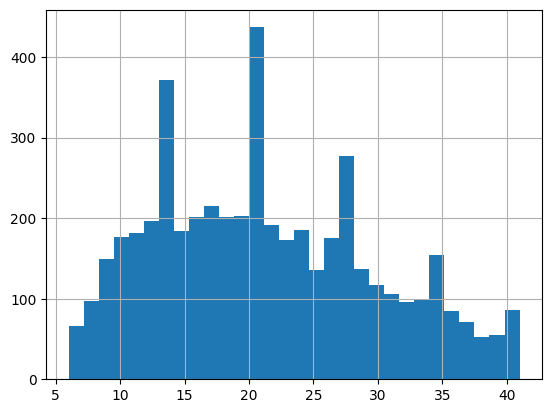

In [ ]:
df_fuck2 = pd.read_excel("backup_v5/final_df6B.xlsx")
df_fuck2.text_tok.hist(bins=30)
len(df_fuck2)

In [ ]:
emotion_to_sentiment = {
    "JOY": "POSITIVE",
    "SURPRISE": "POSITIVE",
    "SADNESS": "NEGATIVE",
    "DISGUST": "NEGATIVE",
    "ANGER": "NEGATIVE",
    "FEAR": "NEGATIVE"
}

In [217]:
from sklearn.model_selection import train_test_split

final_df6B_train, temp_df = train_test_split(df_fuck2, test_size=0.2, random_state=42, stratify=df_fuck2['emotion'])
final_df6B_val, final_df6B_test = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion'])

print(final_df6B_train.emotion.value_counts(normalize=True))
print(final_df6B_val.emotion.value_counts(normalize=True))
print(final_df6B_test.emotion.value_counts(normalize=True))
print(len(df_fuck2), len(final_df6B_train), len(final_df6B_val), len(final_df6B_test))

emotion
JOY         0.298129
SADNESS     0.280185
DISGUST     0.249167
ANGER       0.115355
FEAR        0.042553
SURPRISE    0.014612
Name: proportion, dtype: float64
emotion
JOY         0.297131
SADNESS     0.280738
DISGUST     0.250000
ANGER       0.114754
FEAR        0.043033
SURPRISE    0.014344
Name: proportion, dtype: float64
emotion
JOY         0.299180
SADNESS     0.278689
DISGUST     0.247951
ANGER       0.116803
FEAR        0.043033
SURPRISE    0.014344
Name: proportion, dtype: float64
4877 3901 488 488


In [221]:
emotion_to_sentiment = {
    "JOY": "POSITIVE",
    "SURPRISE": "POSITIVE",
    "SADNESS": "NEGATIVE",
    "DISGUST": "NEGATIVE",
    "ANGER": "NEGATIVE",
    "FEAR": "NEGATIVE"
}

final_df6B_train["sentiment"] = final_df6B_train["emotion"].map(emotion_to_sentiment)
final_df6B_train.rename(columns={"sentiment":"emotion", "emotion":"sentiment"}, inplace=True)

final_df6B_val["sentiment"] = final_df6B_val["emotion"].map(emotion_to_sentiment)
final_df6B_val.rename(columns={"sentiment":"emotion", "emotion":"sentiment"}, inplace=True)

final_df6B_test["sentiment"] = final_df6B_test["emotion"].map(emotion_to_sentiment)
final_df6B_test.rename(columns={"sentiment":"emotion", "emotion":"sentiment"}, inplace=True)

In [226]:
final_df6B_train.head(3)

,original_text,text,aspect,opinion,sentiment,opinion_tok,text_tok,emotion
3879,"Today, at this moment I see Russia is killing ...","Today, at this moment I see Russia is killing ...",Russia,is killing Ukraine people,ANGER,6,27,NEGATIVE
1933,Thank you so much for sharing and this is exac...,Openly racist statements and policies aren’t c...,racist statements and policies,aren’t commonplace,JOY,6,12,POSITIVE
1474,"Rather than solve the underlying issues, they ...",Can’t increase birth rate since eons times ago...,mass importing,plug gap measure,DISGUST,5,28,NEGATIVE


In [227]:
final_df6B_val.head(3)

,original_text,text,aspect,opinion,sentiment,opinion_tok,text_tok,emotion
3635,"Indeed, what I am saying is that as a result y...",But yes I guess the system is pretty ingrained...,old British system,sucks due to scorekeeping,DISGUST,7,40,NEGATIVE
3783,god bless them all the people.,god bless them all the people.,people,god bless them,JOY,5,9,POSITIVE
372,app users blocking the queue for chad token ppl,app users blocking the queue for chad token ppl,app users,blocking the queue,ANGER,5,12,NEGATIVE


In [228]:
final_df6B_test.head(3)

,original_text,text,aspect,opinion,sentiment,opinion_tok,text_tok,emotion
833,It's really curious why Singapore continues to...,Seems to me that higher government spending is...,Biden,was doing in the US,DISGUST,7,35,NEGATIVE
2556,Alex Yeong They should only be abled to deploy...,Most MNC import Ali Baba 3rd world workers und...,foreign talents,under the pretext,DISGUST,6,21,NEGATIVE
1744,"it doesn't excuse what they do, excusing child...",the humanity part of educating against racism ...,educating against racism,is gone,SADNESS,4,38,NEGATIVE


In [ ]:
final_df6B_train.to_excel("../data/dataset3_train.xlsx", index=False)
final_df6B_val.to_excel("../data/dataset3_val.xlsx", index=False)
final_df6B_test.to_excel("../data/dataset3_test.xlsx", index=False)

In [220]:
final_df6B_test

,original_text,text,aspect,opinion,emotion,opinion_tok,text_tok
833,It's really curious why Singapore continues to...,Seems to me that higher government spending is...,Biden,was doing in the US,DISGUST,7,35
2556,Alex Yeong They should only be abled to deploy...,Most MNC import Ali Baba 3rd world workers und...,foreign talents,under the pretext,DISGUST,6,21
1744,"it doesn't excuse what they do, excusing child...",the humanity part of educating against racism ...,educating against racism,is gone,SADNESS,4,38
2037,I had to stop reading the comment section afte...,So many people are completely missing the point.,people,missing the point,ANGER,5,11
3050,Smelly tofu isn't even a key cultural part of ...,"You should study chemistry, laugh my ass out",You,should study chemistry,DISGUST,5,10
...,...,...,...,...,...,...,...
2400,"lol,hdb not mine,car not mine,job security not...","lol,hdb not mine,car not mine,job security not...",HDB,not mine,SADNESS,4,27
2373,All the innocent lives killed in Russia and Uk...,Little children who had their lives ahead of t...,little children,RIP,SADNESS,3,18
2529,Just wanted to share that I finally tried cycl...,I will ride back home later after work so fing...,bicycle,nobody is cheap enough to steal,FEAR,8,23
1372,Sudhir Menon Well if Putin presses the nuclear...,Well if Putin presses the nuclear button - WW3...,WW3,will not last for years,SADNESS,7,29


### Summary of changes

- final_df6 to final_df7: Dropping unclear sentiment and opinion verbs
- final_df7 to final_df8: Remove URLs and convert demojize emojis into proper descriptions and append them to the end of sentences
- final_df8 to final_df6B: Dropped the entire neutral emotion because a lot of the segments does not make sense, and the grouping seems to be a lazy grouping. Manually vet the things

In [ ]:
import pandas as pd

final_df6 = pd.read_excel("backup_v5/final_df6.xlsx")
final_df6B = pd.read_excel("backup_v5/final_df6B.xlsx")

In [4]:
print(final_df6.emotion.value_counts())
print(final_df6.emotion.value_counts(True))

emotion
NEUTRAL     3420
JOY         1964
SADNESS     1886
DISGUST     1782
ANGER        746
FEAR         286
SURPRISE     102
Name: count, dtype: int64
emotion
NEUTRAL     0.335755
JOY         0.192814
SADNESS     0.185156
DISGUST     0.174946
ANGER       0.073238
FEAR        0.028078
SURPRISE    0.010014
Name: proportion, dtype: float64


In [5]:
print(final_df6B.emotion.value_counts())
print(final_df6B.emotion.value_counts(True))

emotion
JOY         1454
SADNESS     1366
DISGUST     1215
ANGER        563
FEAR         208
SURPRISE      71
Name: count, dtype: int64
emotion
JOY         0.298134
SADNESS     0.280090
DISGUST     0.249129
ANGER       0.115440
FEAR        0.042649
SURPRISE    0.014558
Name: proportion, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split

final_df6_train, temp_df = train_test_split(final_df6, test_size=0.2, random_state=42, stratify=final_df6['emotion'])
final_df6_val, final_df6_test = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion'])

In [ ]:
final_df6_train.to_excel("../data/dataset2_train.xlsx", index=False)
final_df6_val.to_excel("../data/dataset2_val.xlsx", index=False)
final_df6_test.to_excel("../data/dataset2_test.xlsx", index=False)

In [ ]:
# Data 2: (see paper)
# final_df6_train.xlsx, final_df6_val.xlsx, final_df6_test.xlsx

# Data 3: (see paper)
# final_df6B_train.xlsx, final_df6B_val.xlsx, final_df6B_test.xlsx